# Feature Engineering – Uber Taxi Fare Prediction

In this notebook, we perform feature engineering and data cleaning on the Uber taxi fare dataset.  
The main goals are:
- Convert and extract useful time-based features  
- Calculate trip distance using pickup and dropoff coordinates  
- Remove obvious outliers and inconsistent records  
- Save a cleaned dataset for modeling

In [3]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
file_path=r"C:\Users\USER\OneDrive\Belgeler\uber.csv"
df=pd.read_csv(file_path)
print("shape of the original dataset:",df.shape)
df.head()

shape of the original dataset: (200000, 9)


,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [4]:
print("pickup_datetime type before conversion:", df['pickup_datetime'].dtype)
print(df['pickup_datetime'].head())
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')
print("\npickup_datetime type after conversion:", df['pickup_datetime'].dtype)
df['pickup_datetime'].head()

pickup_datetime type before conversion: object
0    2015-05-07 19:52:06 UTC
1    2009-07-17 20:04:56 UTC
2    2009-08-24 21:45:00 UTC
3    2009-06-26 08:22:21 UTC
4    2014-08-28 17:47:00 UTC
Name: pickup_datetime, dtype: object

pickup_datetime type after conversion: datetime64[ns, UTC]


0   2015-05-07 19:52:06+00:00
1   2009-07-17 20:04:56+00:00
2   2009-08-24 21:45:00+00:00
3   2009-06-26 08:22:21+00:00
4   2014-08-28 17:47:00+00:00
Name: pickup_datetime, dtype: datetime64[ns, UTC]

In [5]:
df['pickup_year'] = df['pickup_datetime'].dt.year
df['pickup_month'] = df['pickup_datetime'].dt.month
df['pickup_day'] = df['pickup_datetime'].dt.day
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['pickup_weekday'] = df['pickup_datetime'].dt.weekday  # Monday=0, Sunday=6
df[['pickup_datetime', 'pickup_year', 'pickup_month', 'pickup_day', 'pickup_hour', 'pickup_weekday']].head()

,pickup_datetime,pickup_year,pickup_month,pickup_day,pickup_hour,pickup_weekday
0,2015-05-07 19:52:06+00:00,2015,5,7,19,3
1,2009-07-17 20:04:56+00:00,2009,7,17,20,4
2,2009-08-24 21:45:00+00:00,2009,8,24,21,0
3,2009-06-26 08:22:21+00:00,2009,6,26,8,4
4,2014-08-28 17:47:00+00:00,2014,8,28,17,3


In [8]:
df['distance_km'] = haversine_distance(
    df['pickup_latitude'],
    df['pickup_longitude'],
    df['dropoff_latitude'],
    df['dropoff_longitude']
)

df[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'distance_km']].head()

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,distance_km
0,40.738354,-73.999817,40.723217,-73.999512,1.683323
1,40.728225,-73.994355,40.750325,-73.994710,2.457590
2,40.740770,-74.005043,40.772647,-73.962565,5.036377
3,40.790844,-73.976124,40.803349,-73.965316,1.661683
4,40.744085,-73.925023,40.761247,-73.973082,4.475450


In [16]:
import numpy as np 
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great-circle distance between two points on the Earth
    specified in decimal degrees. Returns distance in kilometers.
    Works with both scalars and NumPy arrays / Pandas Series.
    """
    R = 6371.0  

    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1.0 - a))

    distance = R * c
    return distance

    # Quick test with fake coordinates (should give a positive number)
test_dist = haversine_distance(40.0, -73.0, 40.5, -73.5)
print("Test distance (km):", test_dist)

Test distance (km): 69.94042916169451


In [9]:
df['distance_km'].describe()

count    199999.000000
mean         20.855350
std         382.964642
min           0.000000
25%           1.215222
50%           2.120992
75%           3.875169
max       16409.239135
Name: distance_km, dtype: float64

In [10]:
print("Rows before dropping missing values:", df.shape[0])

df_clean = df.dropna(subset=[
    'fare_amount', 
    'pickup_datetime',
    'pickup_longitude', 'pickup_latitude',
    'dropoff_longitude', 'dropoff_latitude',
    'passenger_count',
    'distance_km'
])

print("Rows after dropping missing values:", df_clean.shape[0])

Rows before dropping missing values: 200000
Rows after dropping missing values: 199999


In [11]:
print("Rows before outlier removal:", df_clean.shape[0])

df_clean = df_clean[(df_clean['fare_amount'] > 0) & (df_clean['fare_amount'] < 200)]

df_clean = df_clean[(df_clean['passenger_count'] >= 1) & (df_clean['passenger_count'] <= 8)]

df_clean = df_clean[(df_clean['distance_km'] > 0) & (df_clean['distance_km'] < 200)]

print("Rows after outlier removal:", df_clean.shape[0])

Rows before outlier removal: 199999
Rows after outlier removal: 193218


In [12]:
df_clean['fare_amount'].describe(), df_clean['distance_km'].describe(), df_clean['passenger_count'].value_counts()

(count    193218.000000
 mean         11.349721
 std           9.643467
 min           0.010000
 25%           6.000000
 50%           8.500000
 75%          12.500000
 max         196.000000
 Name: fare_amount, dtype: float64,
 count    193218.000000
 mean          3.381830
 std           4.042333
 min           0.000084
 25%           1.280224
 50%           2.180664
 75%           3.941103
 max         177.995633
 Name: distance_km, dtype: float64,
 passenger_count
 1    134159
 2     28569
 5     13562
 3      8627
 6      4154
 4      4147
 Name: count, dtype: int64)

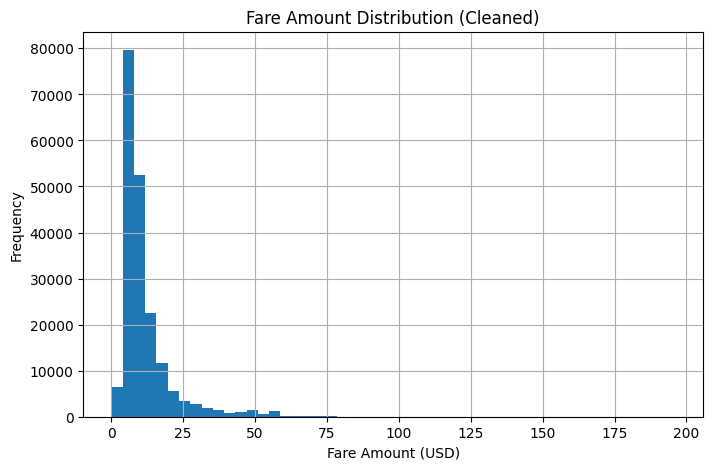

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
df_clean['fare_amount'].hist(bins=50)
plt.title("Fare Amount Distribution (Cleaned)")
plt.xlabel("Fare Amount (USD)")
plt.ylabel("Frequency")
plt.show()

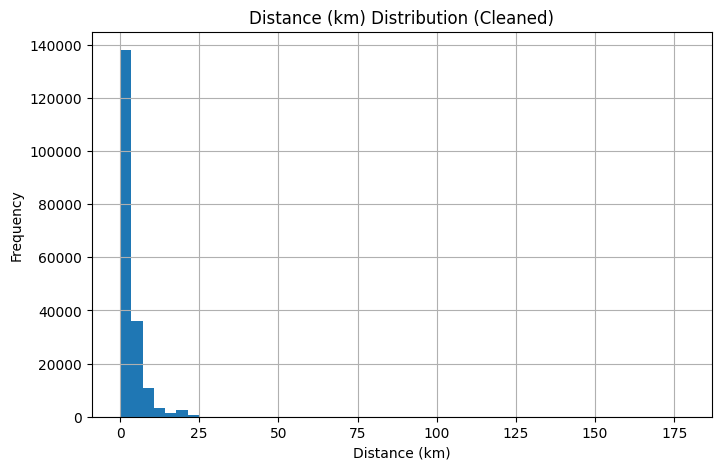

In [14]:
plt.figure(figsize=(8, 5))
df_clean['distance_km'].hist(bins=50)
plt.title("Distance (km) Distribution (Cleaned)")
plt.xlabel("Distance (km)")
plt.ylabel("Frequency")
plt.show()

In [17]:
output_path = "uber_cleaned_data.csv"  
df_clean.to_csv(output_path, index=False)
print(f"Cleaned dataset saved as: {output_path}")
print("Final shape of cleaned data:", df_clean.shape)

Cleaned dataset saved as: uber_cleaned_data.csv
Final shape of cleaned data: (193218, 15)
